# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [3]:
import torch
import numpy as np
from dataset import TextDataset

In [4]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `UNK` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [6]:
from model import LanguageModel

In [7]:
model = LanguageModel(train_set)

In [8]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [9]:
DEVICE = None

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

DEVICE

device(type='cpu')

In [10]:
from torch.utils.data import Dataset, DataLoader

BATCH_SIZE = 256
EPOCHS = 20


train_data = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='tokenizer')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='tokenizer')
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
from torch import nn
from torch import optim
import train


model = LanguageModel(val_data).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
)

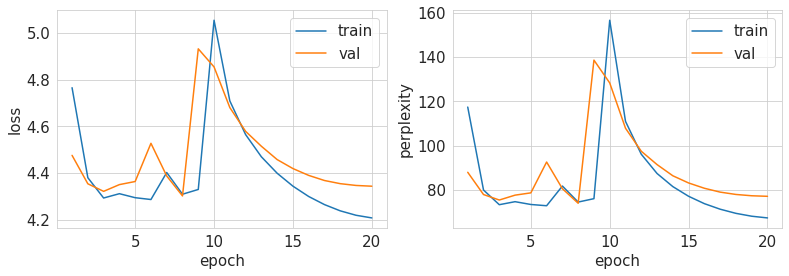

Generation examples after epoch=20:
так хорошо трена ваики тебя тогда  ⁇ 00 оборачиваю где.  ⁇  ситуация?
воздышин! велиспался регулярная.- а где же тогда я вкусную страх шанс ис. карда среди со двоет тернте- мы у вас?- дай парень, когда у меня биографирот, и ты на работе, кидает лошадь?- и баобоче.
новый- ну, мне мне работа?- слов?.
солдат загнили... пов стрел с париглое, да он наруса.
никогда не пол мои мысли-то думала бы твоим в одну.- я, наверное, а когда ты называешь им не о вас...вод с геобек на то и по службух...- а как ты думаешь, что залещенные - это когда выв будет не открыть, с десять чикатная покушку - номещеру, оставайся история вонсов- что, поносих, да надо объявление.



In [16]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [17]:
torch.save(model.state_dict(), 'classic_rnn.model')
torch.save(optimizer.state_dict(), 'opt_classic_rnn.model')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [18]:
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
)


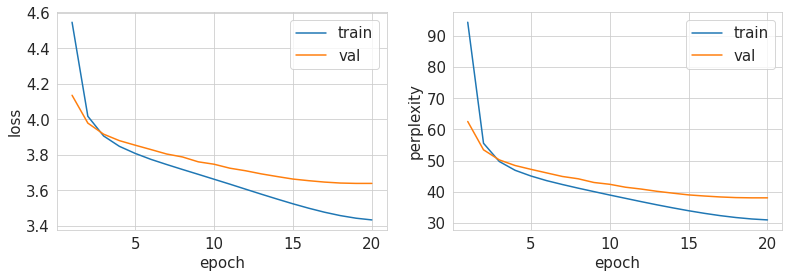

Generation examples after epoch=20:
а ведь мы пришел на крыше и смотреть на рыбалку, а учить его столько и вредного чемодана.
- привет, как меви дя суд на меня - колбаски, ну зачем?- она такая по старости неприятность, а уходит.- а почему лучше в цвет употребления?- как?! трогал майк.
таксее, оказывается, но так все произойдут.вырящи в стадок, это всегда любой личная жизнь.- а ты еще и теперь можно только мне.
сегодня я проглотил из себя конец света.
вчера потесту муж у устал вчера выпила себе потрясюбры щаву, она маленькая, покатая беспирожена. ненавидел в другую сторону.



In [19]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [20]:
torch.save(model.state_dict(), 'lstm.model')
torch.save(optimizer.state_dict(), 'opt_lstm.model')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [21]:
temps = np.linspace(0.1, 2, 10)
num_examples = 3
prefix = 'Грузин подходит к отцу'

for temp in temps:
    print(f'Generation examples for {temp=}:')
    for _ in range(num_examples):
        print(model.inference(prefix=prefix))
    print()

Generation examples for temp=0.1:
грузин подходит к отцу и говорит- ну, кто - двигатный?- ходил.- ну, сынок, ты смогу тебе рассказать?- так дыочек ты читаешь.
грузин подходит к отцу- закомжать только с парашютистом.- как же?- ну пока сбросился сын.- ты лжок?- вместо малои урок.
грузин подходит к отцулую гинекологу бернет. подходит одна эвакана жены.- сколько ягото о крыло страховика?- я сдачу. поэтому что-то случилось, и я думал.- да ладно, да.- да для вас нельзя у это монстры, но, хотя бы?- судья клиха не выдерживает.

Generation examples for temp=0.3111111111111111:
грузин подходит к отцу- вчера мы купили свой автомат на комп - ел! развелся лень! с чего ты квартиравил?
грузин подходит к отцу- почем потушку пилота чели?- нет, я буду высшаюсь.
грузин подходит к отцу и видит - компюмером и с подругой мужчинами трупляет называет внучка.

Generation examples for temp=0.5222222222222223:
грузин подходит к отцу и говорит- вовочка, приехал сегодня с рыбалки с женой, саша от дыха он сидит.- у

In [22]:
temps = np.linspace(0.1, 2, 10)
num_examples = 3
prefix = 'Пришел, увидел, '

for temp in temps:
    print(f'Generation examples for {temp=}:')
    for _ in range(num_examples):
        print(model.inference(prefix=prefix))
    print()

Generation examples for temp=0.1:
пришел, увидел, как сволочь- соль, батюшка, я не почебовала твоей руки...
пришел, увидел, как оказался, все ног в не видел, но не шли.
пришел, увидел, что новогодней сквощения маяки ныряли! поэтому яку пойду - слева!

Generation examples for temp=0.3111111111111111:
пришел, увидел, как привлечь кефир дом. свел подумал иго подумал - запомнил...
пришел, увидел, вышел ночью случайно, иван пришел ним спас ссулением к касснушем. забулчик.
пришел, увидел, как наблюдается на столе. вчера отрочил распущенный стол, стоит немного в садик и она по реже сказал пару с надписью принца и камчатку его сорвался. когда я виноват, дай ему голову, заправки цену, я мужик кивнулся с песрогующего михаил дефером...

Generation examples for temp=0.5222222222222223:
пришел, увидел, как понял, что ее в кастрю хоркуляличные понадобятся одним шарик и чудесам.
пришел, увидел, как собака полностью, тут болезни- да эти короче тоже ушло.муж- дорогая, самые ужасные и меня, ну зачем, на

In [23]:
temps = np.linspace(0.1, 2, 10)
num_examples = 3
prefix = 'Путин в маршрутке'

for temp in temps:
    print(f'Generation examples for {temp=}:')
    for _ in range(num_examples):
        print(model.inference(prefix=prefix))
    print()

Generation examples for temp=0.1:
путин в маршрутке. так, сейчас никогда не гнус будет больше жить в комнату и собчак минутой, большим и пиро раньше, прежбы. дрались недовольвались...
путин в маршрутке, круг на наследчиках начал обвязывать фильм пылизма, и все то установи... объясните во мне дверь всашающих старое или дураками!
путин в маршрутке. на медведя услышал толкомна.

Generation examples for temp=0.3111111111111111:
путин в маршрутке объедился в организм, представля ему независимости за взломанию.
путин в маршрутке родился, что даже надета сказано удоеньший пости держится на непуталья, ни смогли его документы всю ночь.
путин в маршрутке за компьютер пополнение, всегда и в россии школьных ситуации.

Generation examples for temp=0.5222222222222223:
путин в маршрутке жду-желеткол весь ракат между роддом.
путин в маршрутке спол пилоси гулянные аппетит, потом к томулицей, что у папы карло есть ни одному знакомого море, а потом расходятся.
путин в маршрутке русских гадости создали во

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [24]:
train_data = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, sp_model_prefix='tokenizer_5000')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, sp_model_prefix='tokenizer_5000')
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
)


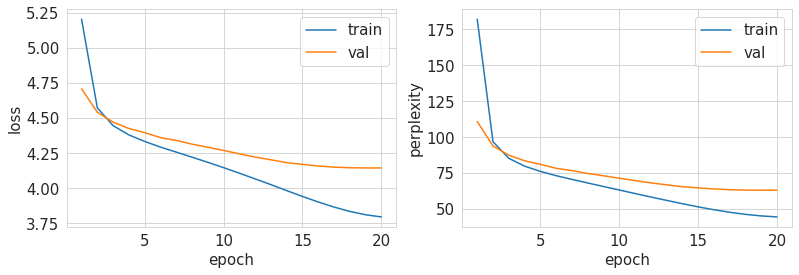

Generation examples after epoch=20:
школьницы, который ходил в любишь дни л настолько, я идти на работу в трусах и лег армию.
однажды мой мобильный муж утон заговил в очереди за прокладок для желания, чтобы его спасать мусор.
- что-то ты соц помнишь вообще два шашься до самого большие?- гаишник!
- я электро и аккурат, чтобы использовать с такого вперед ведь печальнее хозяйственные. главное в поле делать, пожалуйста.
не нужно 10 раздеть дорогу, ни одного визного.



In [26]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [27]:
torch.save(model.state_dict(), 'lstm5000.model')
torch.save(optimizer.state_dict(), 'opt_lstm5000.model')

In [28]:
train_data = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, model_type='unigram', sp_model_prefix='tokenizer_unigram5000')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, model_type='unigram', sp_model_prefix='tokenizer_unigram5000')
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
)


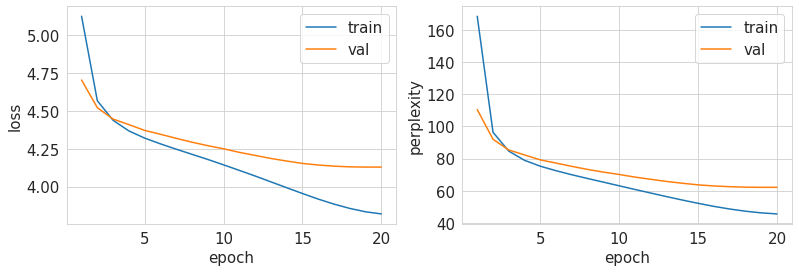

Generation examples after epoch=20:
цельительного голосового одежды в банке выводит изо всех сил и перед глазами сколько есть бабки? уходят когда дети через впереди не было много лет, а сами падали.
основной инквисией нанакрезеной миколкость по случаю развестись с собой, как и делаю пиццу.
- на вот  включенели воды и единственное кабинетом, если все женщины не возможность остановиться в его новомиграм.
- я тебя не люблю, когда спишь.- а что у тебя там сейчас?- навижу оставался только один!
лучше съезды на ушло, чем доходили мир и на стол одного района.



In [30]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [31]:
torch.save(model.state_dict(), 'lstm_unigram5000.model')
torch.save(optimizer.state_dict(), 'opt_lstm_unigram5000.model')

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


def lsa(model: LanguageModel):
    val_data = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='tokenizer')
    n = len(val_data)

    texts = []
    for tokens, _ in val_data:
        texts.append(val_data.ids2text(tokens))

    for _ in range(n):
        texts.append(model.inference())

    vectorizer = TfidfVectorizer().fit(texts)
    texts_tf_idf = vectorizer.transform(texts).T

    svd = TruncatedSVD(n_components=42, random_state=42).fit(texts_tf_idf)

    vectors_val = svd.components_[:, :n]
    vectors_generated = svd.components_[:, n:]

    lsa = np.mean(np.max(cosine_similarity(vectors_val.T, vectors_generated.T), axis = 0))
    
    return lsa, vectors_val, vectors_generated


In [20]:
val_data = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='tokenizer')
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
model.load_state_dict(torch.load('lstm.model', map_location=torch.device(DEVICE)))
model.eval()

lstm_lsa, lstm_v_val, lstm_v_gen = lsa(model)
lstm_lsa

0.8316761016995657

In [21]:
val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, sp_model_prefix='tokenizer_5000')
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
model.load_state_dict(torch.load('lstm5000.model', map_location=torch.device(DEVICE)))
model.eval()

lstm5000_lsa, lstm5000_v_val, lstm5000_v_gen = lsa(model)
lstm5000_lsa

0.8333591603553782

In [23]:
val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, model_type='unigram', sp_model_prefix='tokenizer_unigram5000')
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
model.load_state_dict(torch.load('lstm_unigram5000.model', map_location=torch.device(DEVICE)))
model.eval()

lstm_unigram5000_lsa, lstm_unigram5000_v_val, lstm_unigram5000_v_gen = lsa(model)
lstm_unigram5000_lsa

0.8277185631300586

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

sns.set(style='darkgrid')

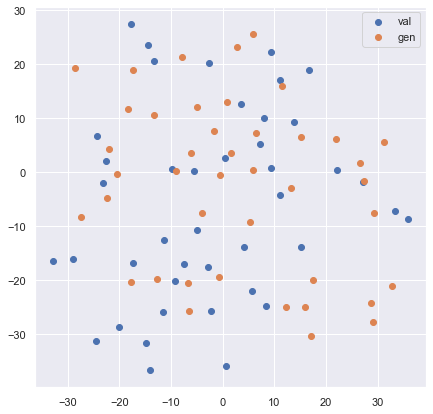

In [39]:
lstm_v_val_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(lstm_v_val)
lstm_v_gen_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(lstm_v_gen)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x=lstm_v_val_embedded.T[0], y=lstm_v_val_embedded.T[1], label='val')
ax.scatter(x=lstm_v_gen_embedded.T[0], y=lstm_v_gen_embedded.T[1], label='gen')

ax.legend()
plt.show()

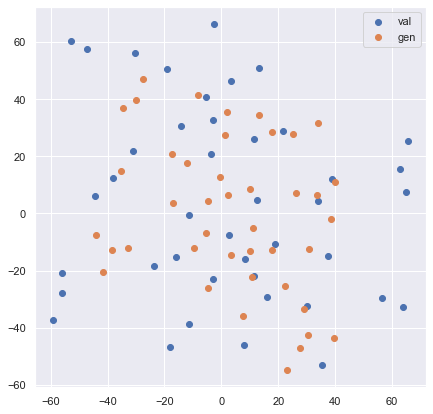

In [40]:
lstm5000_v_val_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(lstm5000_v_val)
lstm5000_v_gen_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(lstm5000_v_gen)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x=lstm5000_v_val_embedded.T[0], y=lstm5000_v_val_embedded.T[1], label='val')
ax.scatter(x=lstm5000_v_gen_embedded.T[0], y=lstm5000_v_gen_embedded.T[1], label='gen')

ax.legend()
plt.show()

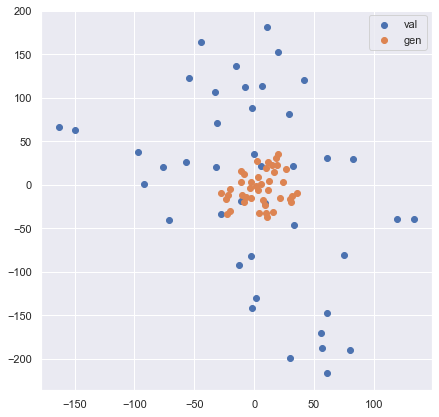

In [41]:
lstm_unigram5000_v_val_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(lstm_unigram5000_v_val)
lstm_unigram5000_v_gen_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(lstm_unigram5000_v_gen)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x=lstm_unigram5000_v_val_embedded.T[0], y=lstm_unigram5000_v_val_embedded.T[1], label='val')
ax.scatter(x=lstm_unigram5000_v_gen_embedded.T[0], y=lstm_unigram5000_v_gen_embedded.T[1], label='gen')

ax.legend()
plt.show()

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.